In [43]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv('QB_2025/mongo_clean.csv')  # Replace with your actual data
metric = 'grades_offense'  # Specify the metric you want to predict

In [45]:
print(df.columns)

Index(['Unnamed: 0', 'player', 'Year', 'Team', 'Previous_twp_rate',
       'Cap_Space', 'Previous_grades_offense', 'Previous_ypa',
       'Previous_qb_rating', 'Previous_grades_pass',
       'Previous_accuracy_percent', 'Previous_btt_rate', 'grades_offense'],
      dtype='object')


In [46]:
columns_to_drop = ['Unnamed: 0']
df = df.drop(columns=columns_to_drop)


In [47]:
df = df.sort_values(by=['Team', 'Year', 'player'])

# Display the sorted data
print(df.head())


               player  Year   Team  Previous_twp_rate  Cap_Space  \
13         Alex Smith  2012  49ers                2.6   7.669983   
116  Colin Kaepernick  2013  49ers                3.0   1.130692   
117  Colin Kaepernick  2014  49ers                4.1   2.832665   
58     Blaine Gabbert  2015  49ers                6.4   1.221385   
118  Colin Kaepernick  2015  49ers                3.5  10.654490   

     Previous_grades_offense  Previous_ypa  Previous_qb_rating  \
13                      78.6           7.1                92.1   
116                     78.8           8.8                99.0   
117                     68.1           7.6                88.7   
58                      38.6           5.6                36.0   
118                     64.5           7.0                86.4   

     Previous_grades_pass  Previous_accuracy_percent  Previous_btt_rate  \
13                   80.1                      0.741                7.4   
116                  82.7                   

In [48]:
player_data = df.groupby('player')
print(player_data.head)


<bound method GroupBy.head of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x17780b080>>


In [49]:
import numpy as np

sequences = []
targets = []
years_seq = []
players_seq = []

# Iterate over each team and its respective data
for player, group in player_data:
    # Ensure the team has at least 4 years of data
    if len(group) >= 4:
        print(f"Processing team: {player}, data length: {len(group)}")  # Debugging: check length of data for each team
        
        # Iterate through the data to create sequences for 3 years
        for i in range(len(group) - 3):
            # Select the relevant columns for the sequence
            sequence = group.iloc[i:i+3][['Previous_twp_rate', 'Cap_Space', 'Previous_grades_offense', 
                                           'Previous_ypa', 'Previous_qb_rating', 'Previous_grades_pass', 
                                           'Previous_accuracy_percent', 'Previous_btt_rate']]  # Add more columns if needed
            
            # The target is the next year's Current_PFF
            target = group.iloc[i+3]['grades_offense']  
            
            sequences.append(sequence.values)  # Add the sequence to the list
            targets.append(target)  # Add the target to the list
            years_seq.append(group.iloc[i+3]['Year'])
            players_seq.append(player)


# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(targets)
years_seq = np.array(years_seq)
players_seq = np.array(players_seq)  # <- add this line



print(f"Total sequences generated: {len(sequences)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Processing team: Aaron Rodgers, data length: 12
Processing team: Alex Smith, data length: 8
Processing team: Andrew Luck, data length: 5
Processing team: Andy Dalton, data length: 12
Processing team: Baker Mayfield, data length: 6
Processing team: Ben Roethlisberger, data length: 9
Processing team: Blaine Gabbert, data length: 6
Processing team: Blake Bortles, data length: 4
Processing team: Brian Hoyer, data length: 4
Processing team: Cam Newton, data length: 9
Processing team: Carson Palmer, data length: 6
Processing team: Carson Wentz, data length: 6
Processing team: Case Keenum, data length: 5
Processing team: Colin Kaepernick, data length: 4
Processing team: Dak Prescott, data length: 8
Processing team: Daniel Jones, data length: 5
Processing team: Derek Carr, data length: 10
Processing team: Deshaun Watson, data length: 6
Processing team: Drew Brees, data length: 9
Processing team: Eli Manning, data length: 8
Processing team: Geno Smith, data length: 5
Processing team: Jacoby Bri

In [50]:
# Train: 2015–2020 targets
train_mask = (years_seq >= 2015) & (years_seq <= 2020)
# Validation: 2021–2022 targets
val_mask = (years_seq >= 2021) & (years_seq <= 2022)
# Test: 2023–2024 targets (optional)
test_mask = (years_seq >= 2023) & (years_seq <= 2024)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]


In [51]:
n_samples, n_timesteps, n_features = X_train.shape
scaler = StandardScaler()
X_train_flat = X_train.reshape(n_samples, n_timesteps * n_features)
X_val_flat = X_val.reshape(X_val.shape[0], n_timesteps * n_features)
X_test_flat = X_test.reshape(X_test.shape[0], n_timesteps * n_features)

scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(n_samples, n_timesteps, n_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape[0], n_timesteps, n_features)


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [53]:
inputs = Input(shape=(3, 8))
dense_input = Dense(16, activation='relu')(inputs)
attention_out = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)
attention_out = LayerNormalization()(attention_out)
rnn_out = SimpleRNN(units=50, activation='relu')(attention_out)
rnn_out = Dropout(0.2)(rnn_out)
output = Dense(1)(rnn_out)
model = Model(inputs=inputs, outputs=output)


In [54]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [55]:
# Early stopping callback to monitor validation loss
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5520.0020 - val_loss: 4502.2568
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4115.1226 - val_loss: 2788.8782
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2334.5569 - val_loss: 601.4675
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 462.5975 - val_loss: 249.0141
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 334.7946 - val_loss: 127.8106
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 237.6737 - val_loss: 124.1068
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 190.8815 - val_loss: 120.4829
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 232.2897 - val_loss: 111.3711
Epoch 9/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164.9553 - val_loss: 109.4618
Epoch 10/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 196.1176 - val_loss: 107.9850
Epoch 11/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148.4236 - val_loss: 107.1454
Epoch 12/80
16/16 ━━━━━━━

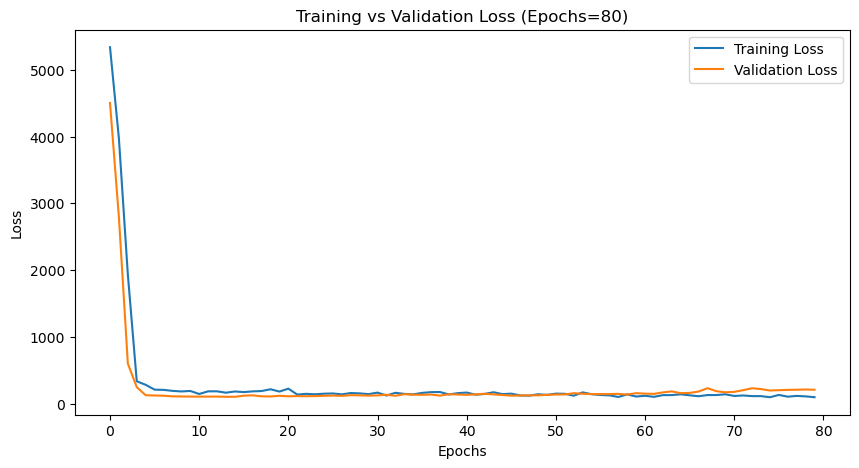

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Validation R² Score: -0.6120


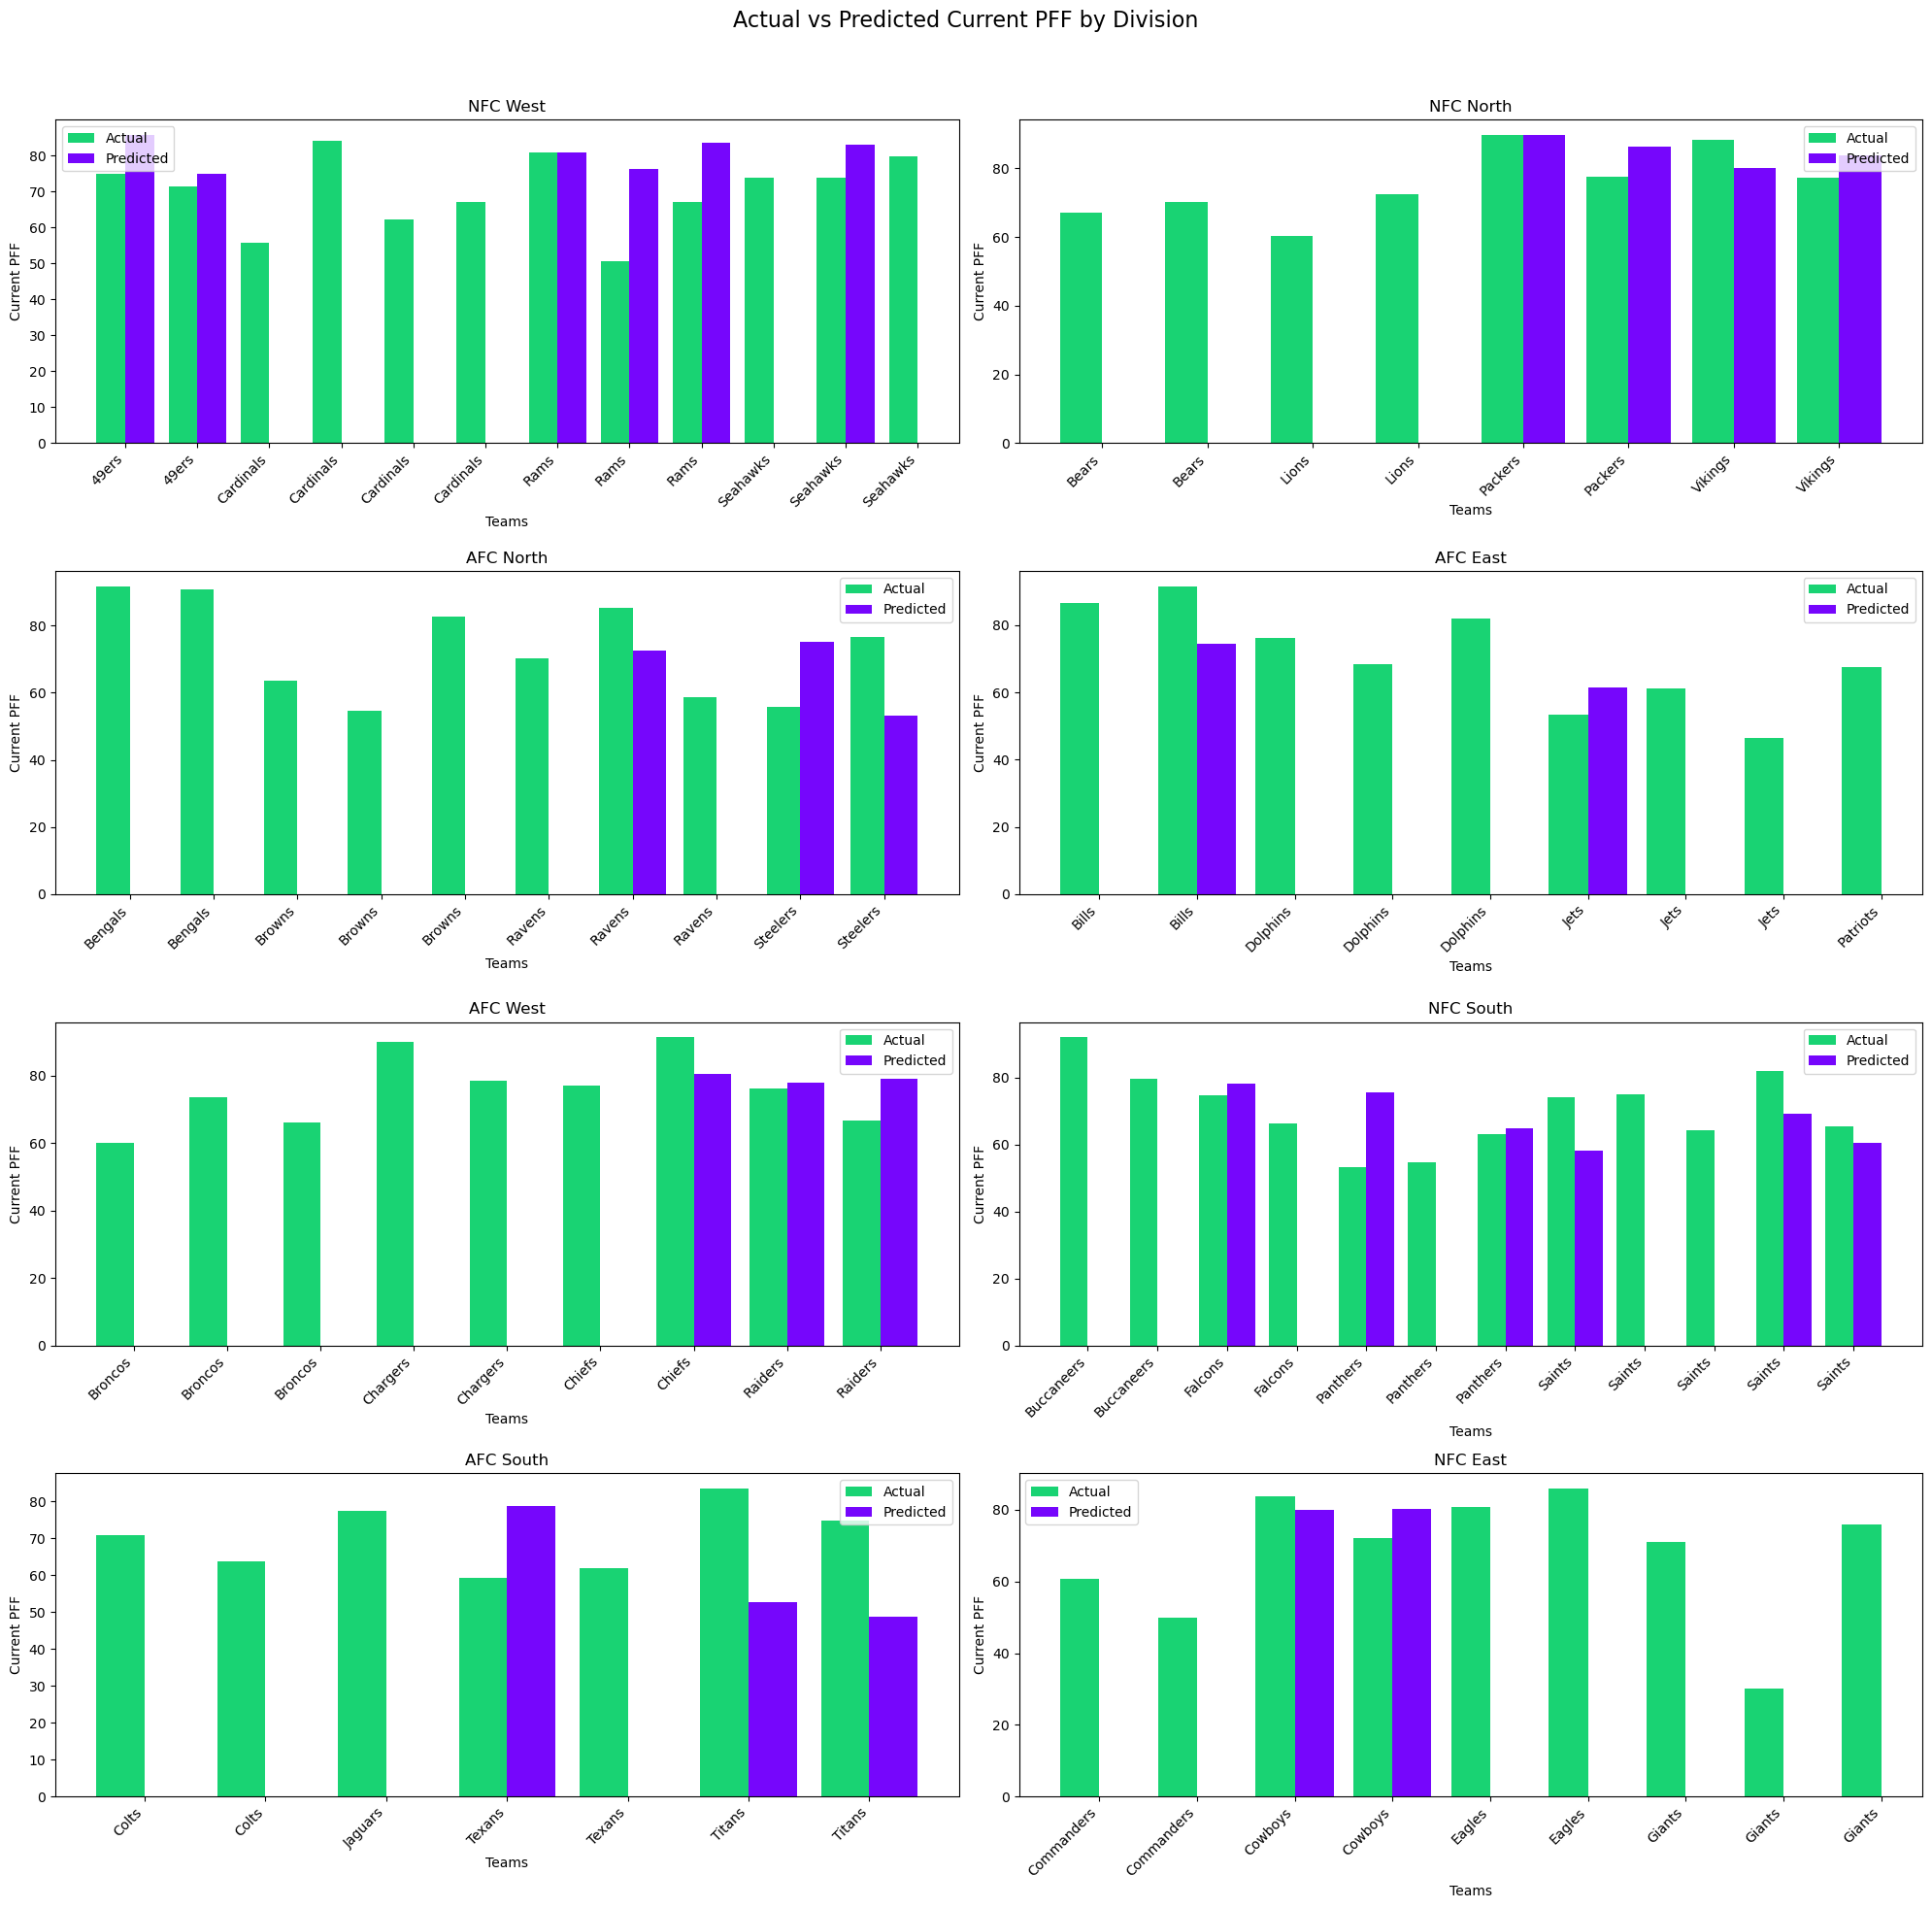

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122.9660 - val_loss: 220.0982
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97.3443 - val_loss: 236.0228
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106.8857 - val_loss: 217.6707
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96.5006 - val_loss: 187.2975
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80.8760 - val_loss: 201.0259
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96.9761 - val_loss: 217.3198
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122.8993 - val_loss: 222.7059
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105.1782 - val_loss: 240.9829
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101.1111 - val_loss: 242.3254
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102.3070 - val_loss: 247.5663
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121.4141 - val_loss: 240.9253
Epoch 12/100
16/16 ━━━━

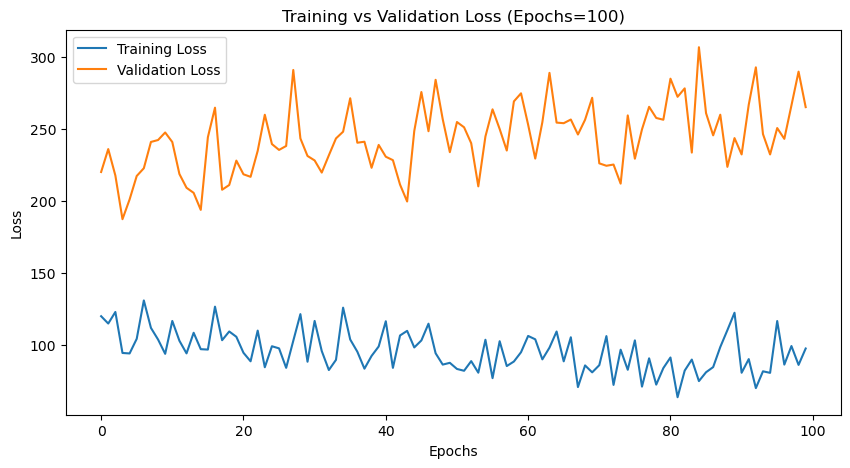

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Validation R² Score: -1.0371


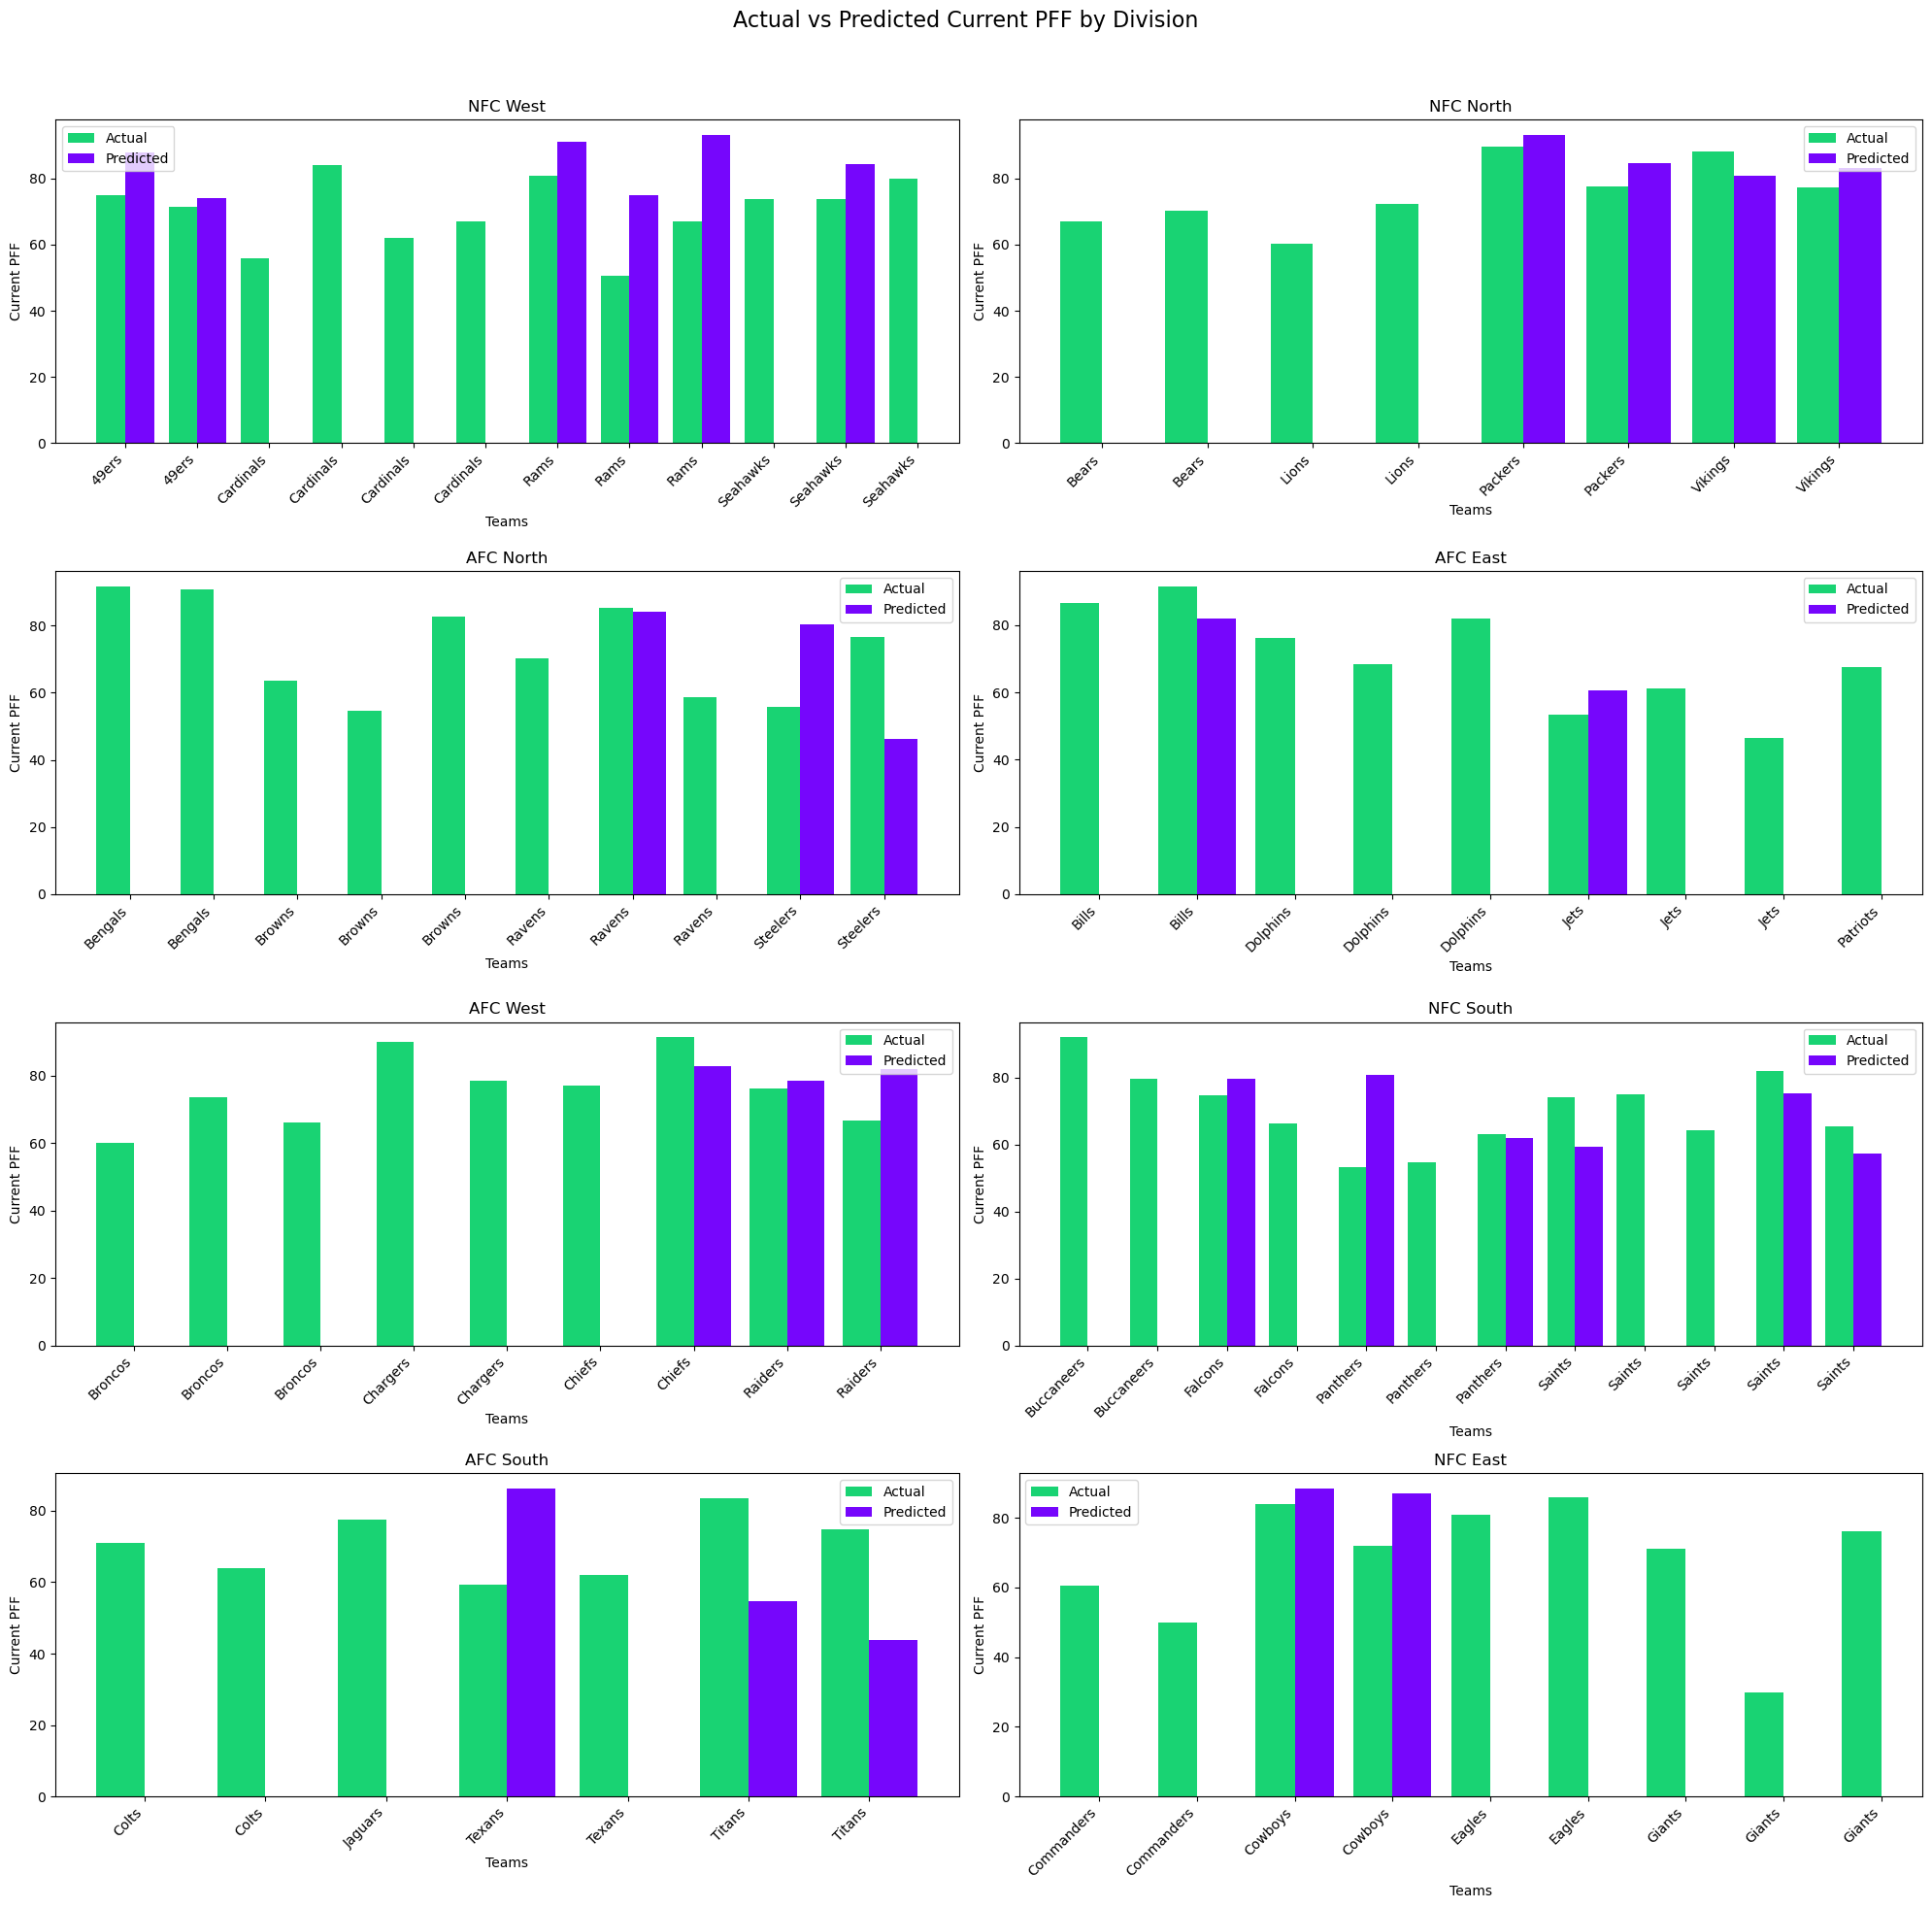

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86.0453 - val_loss: 266.8151
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85.8535 - val_loss: 281.3858
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.1648 - val_loss: 280.8514
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82.4869 - val_loss: 278.7755
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103.9693 - val_loss: 254.7931
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74.2723 - val_loss: 234.3485
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73.6342 - val_loss: 238.8533
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.2726 - val_loss: 226.2713
Epoch 9/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78.9915 - val_loss: 289.6305
Epoch 10/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97.8065 - val_loss: 251.5800
Epoch 11/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 88.9166 - val_loss: 298.5450
Epoch 12/150
16/16 ━━━━━━━━━

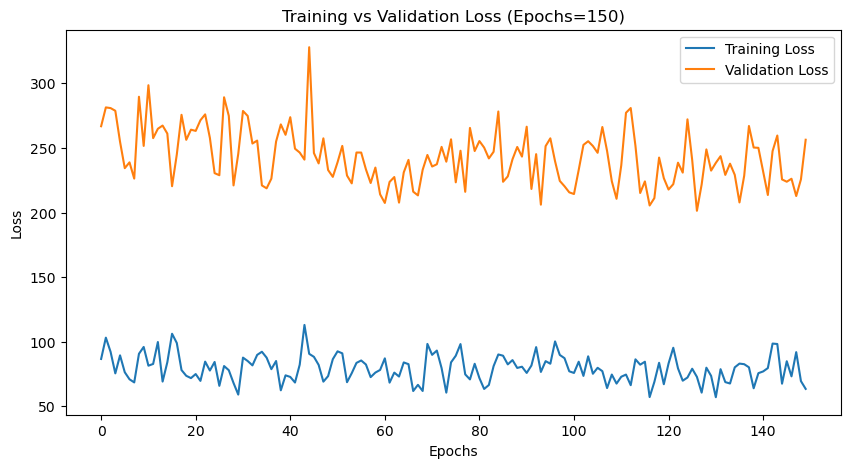

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Validation R² Score: -0.9693


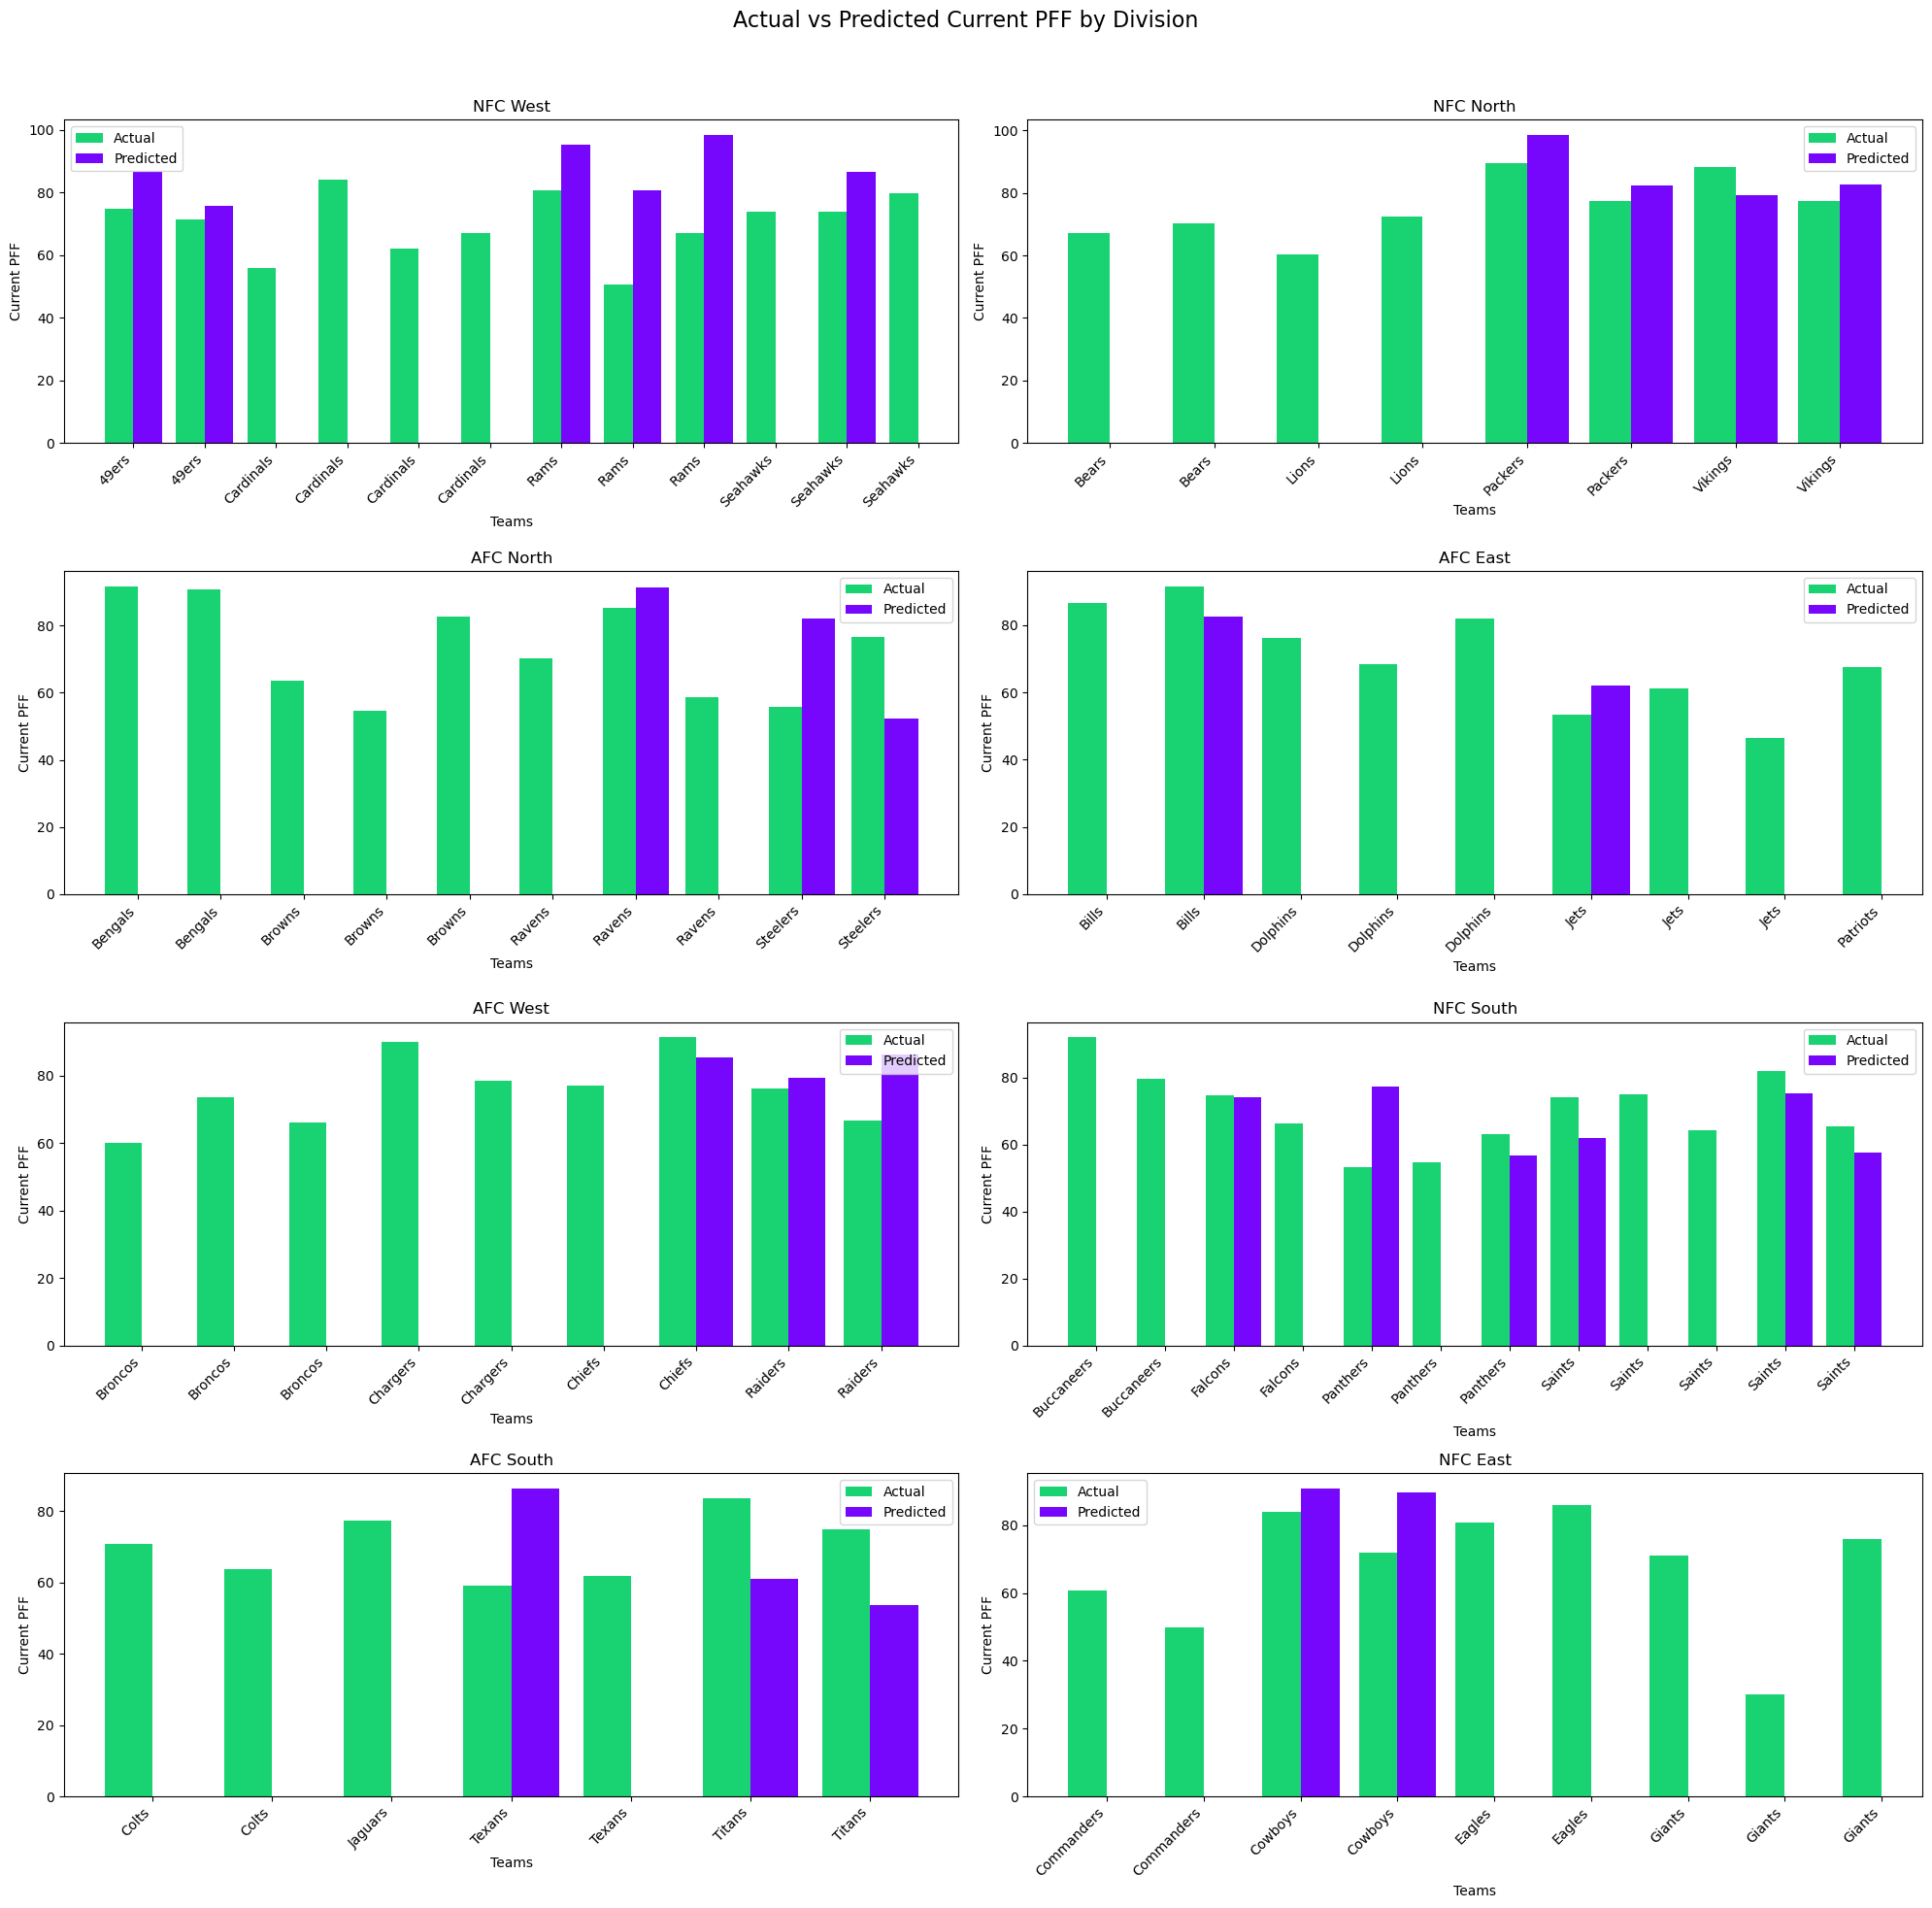

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103.7087 - val_loss: 233.2172
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85.2888 - val_loss: 230.6369
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76.4334 - val_loss: 215.5965
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57.8524 - val_loss: 211.7869
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.9806 - val_loss: 203.5410
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.1286 - val_loss: 217.0276
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.7600 - val_loss: 244.8153
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78.5239 - val_loss: 210.4405
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65.3647 - val_loss: 203.2390
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.2520 - val_loss: 216.2260
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.6904 - val_loss: 237.7801
Epoch 12/200
16/16 ━━━━━━━━━━

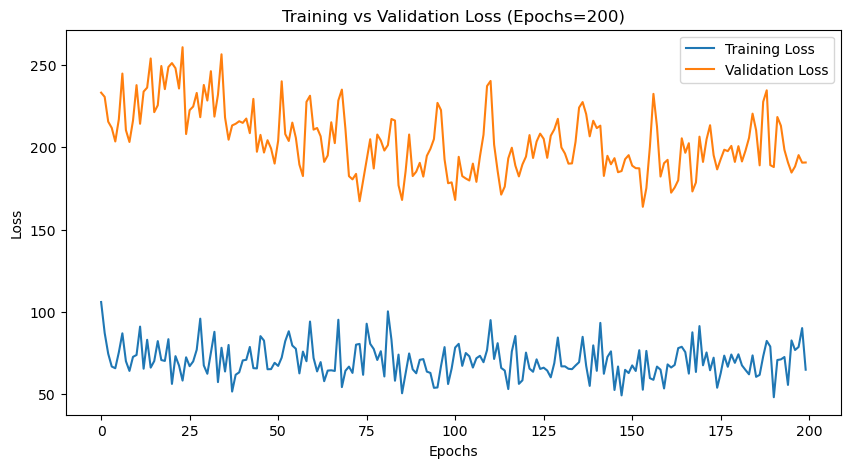

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Validation R² Score: -0.4656


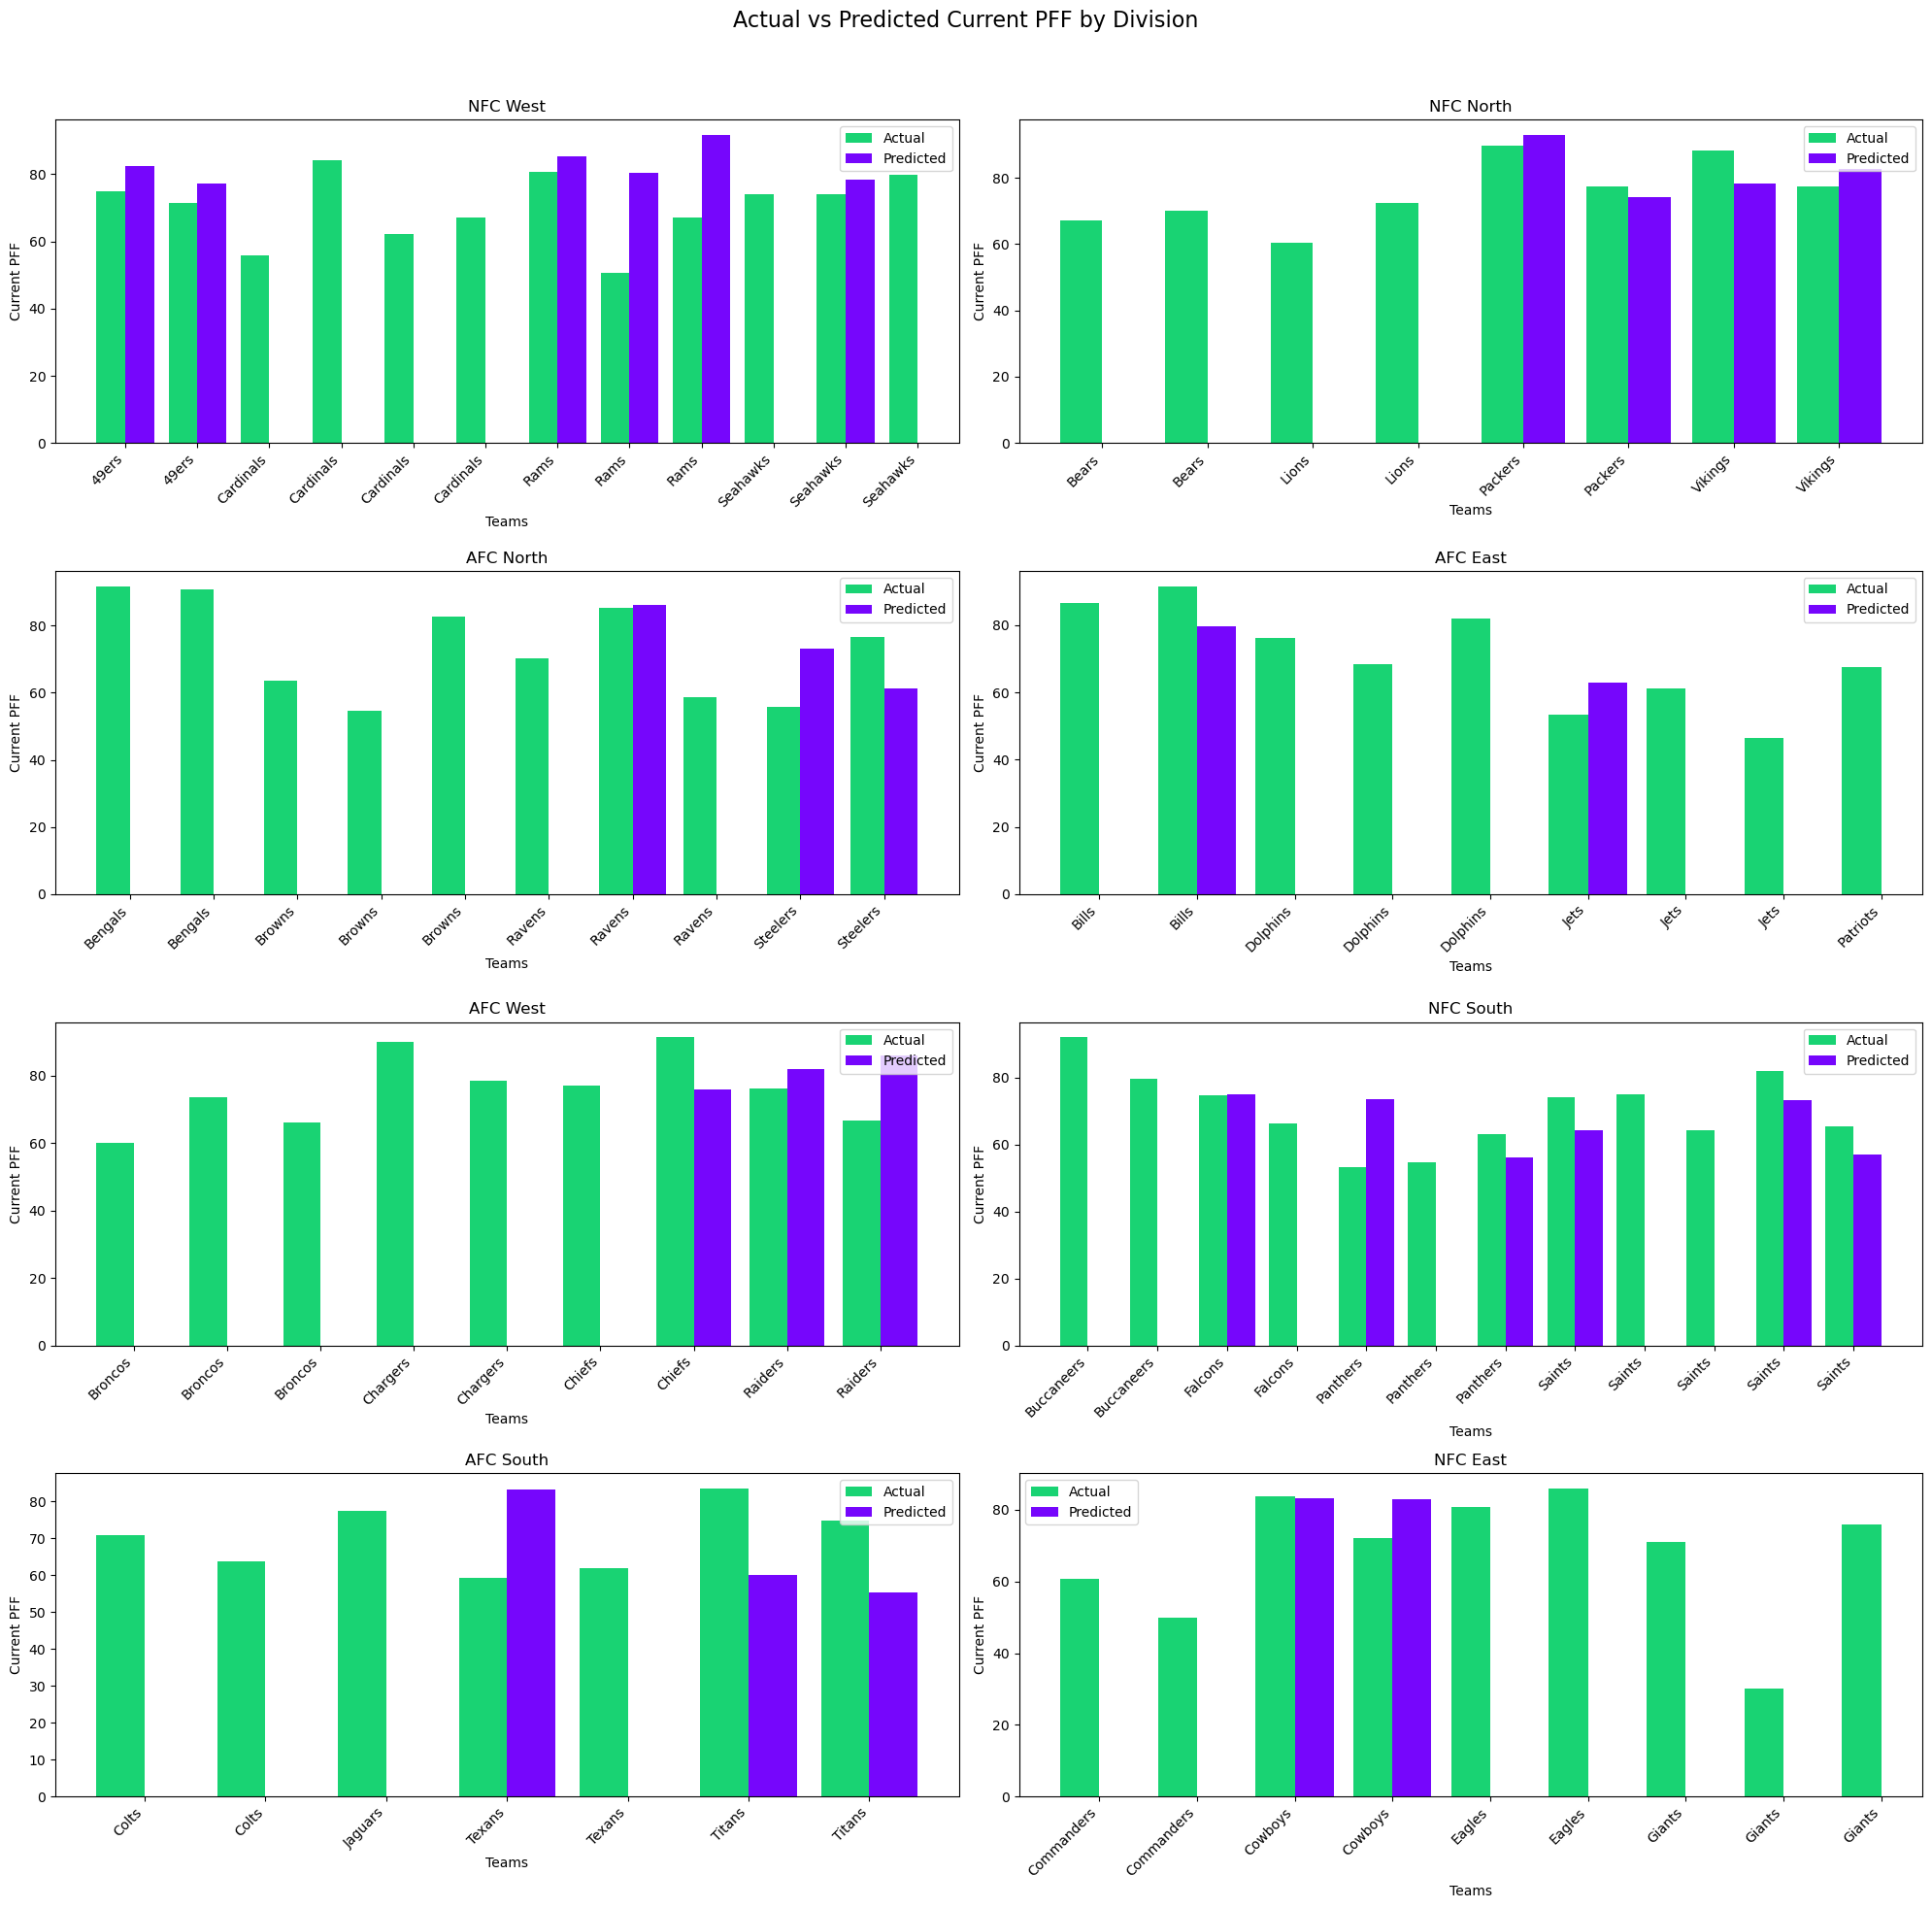

Epoch 1/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82.2609 - val_loss: 203.5736
Epoch 2/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.8515 - val_loss: 178.5652
Epoch 3/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.6793 - val_loss: 178.7456
Epoch 4/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80.3620 - val_loss: 196.0507
Epoch 5/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.6497 - val_loss: 210.9907
Epoch 6/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.3886 - val_loss: 197.8076
Epoch 7/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.1103 - val_loss: 167.2706
Epoch 8/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.4282 - val_loss: 174.4532
Epoch 9/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.1497 - val_loss: 212.6250
Epoch 10/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57.9516 - val_loss: 214.2323
Epoch 11/250
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80.2157 - val_loss: 189.0296
Epoch 12/250
16/16 ━━━━━━━━━━━

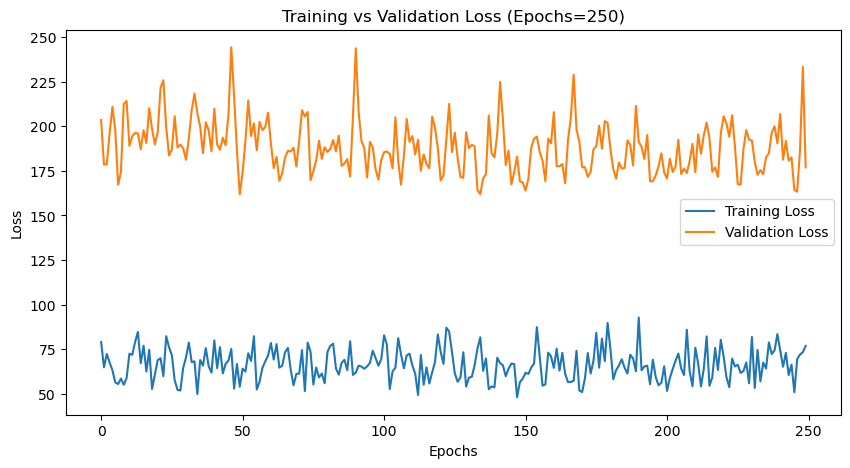

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Validation R² Score: -0.3593


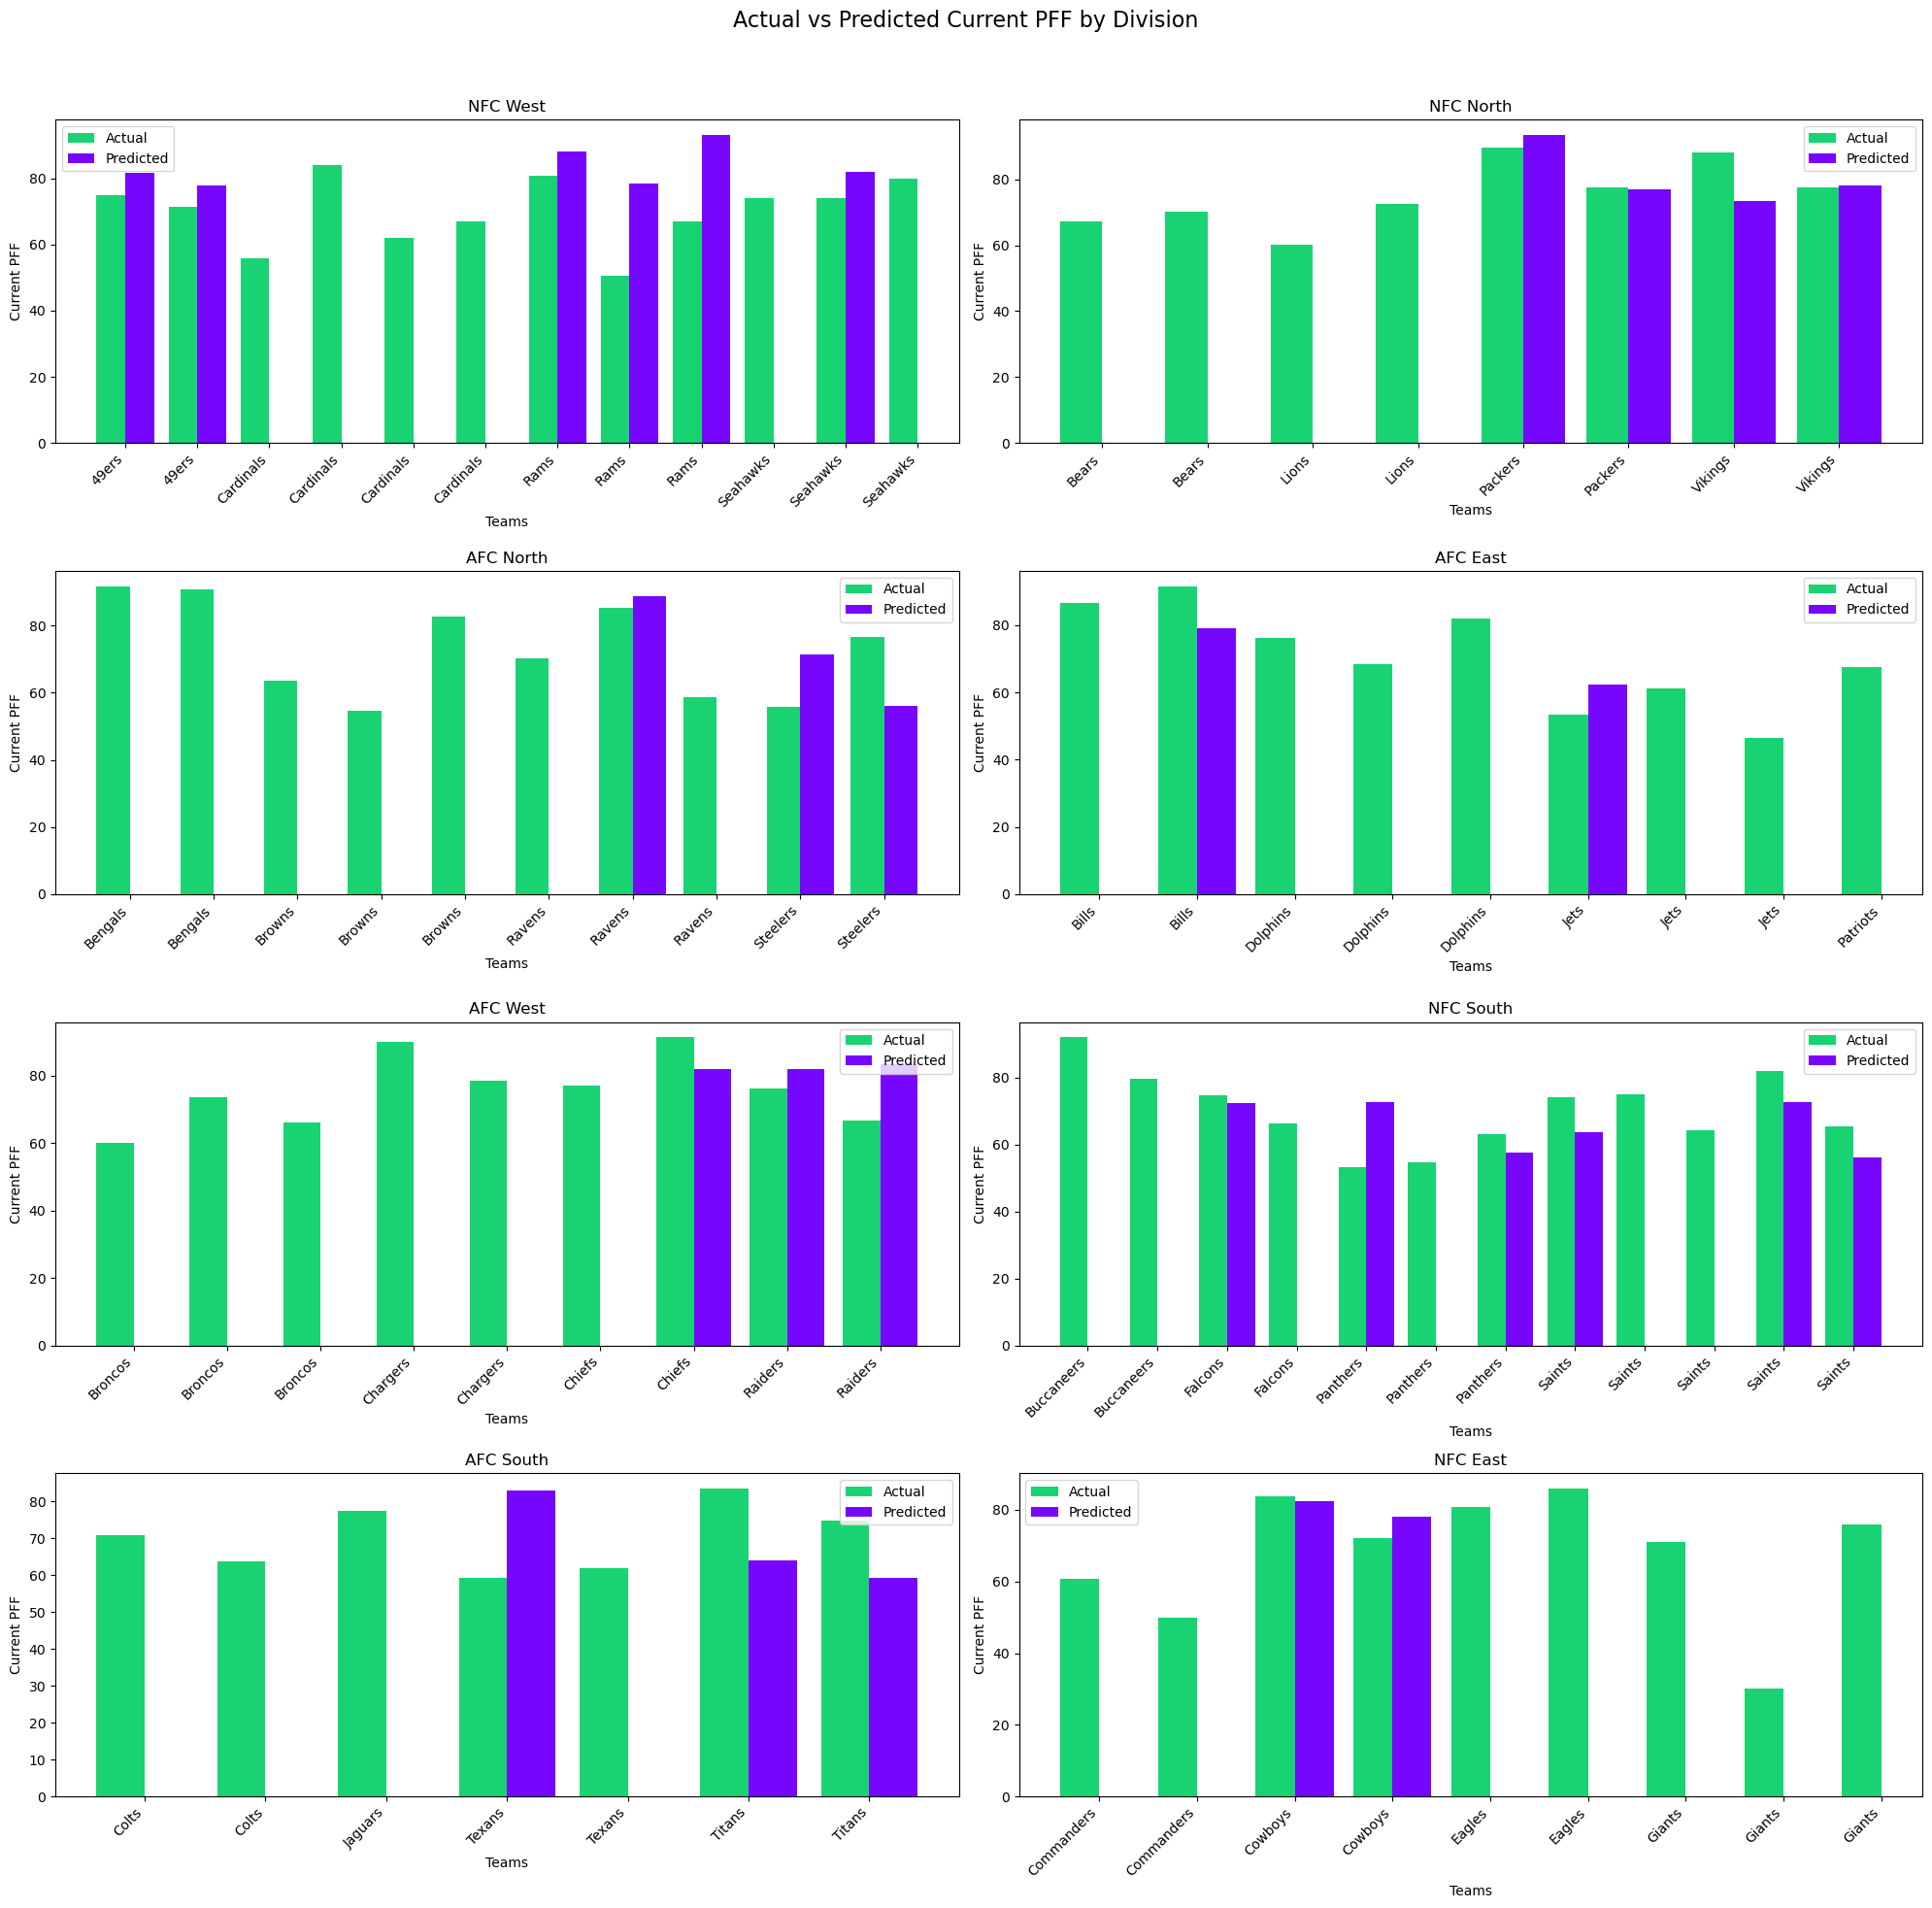

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 76.3118 - val_loss: 174.6135
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58.2358 - val_loss: 182.9821
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55.1437 - val_loss: 190.8075
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71.0839 - val_loss: 185.7771
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.0046 - val_loss: 197.0478
Epoch 6/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74.6067 - val_loss: 191.5665
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75.9411 - val_loss: 211.1223
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87.2688 - val_loss: 169.9298
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.6242 - val_loss: 170.1646
Epoch 10/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66.7933 - val_loss: 205.9200
Epoch 11/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69.5321 - val_loss: 184.4010
Epoch 12/500
16/16 ━━━━━━━━━━━

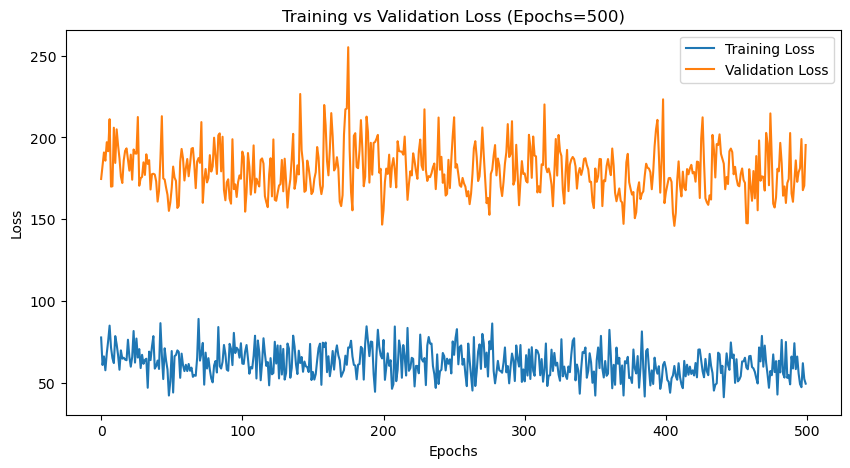

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Validation R² Score: -0.5007


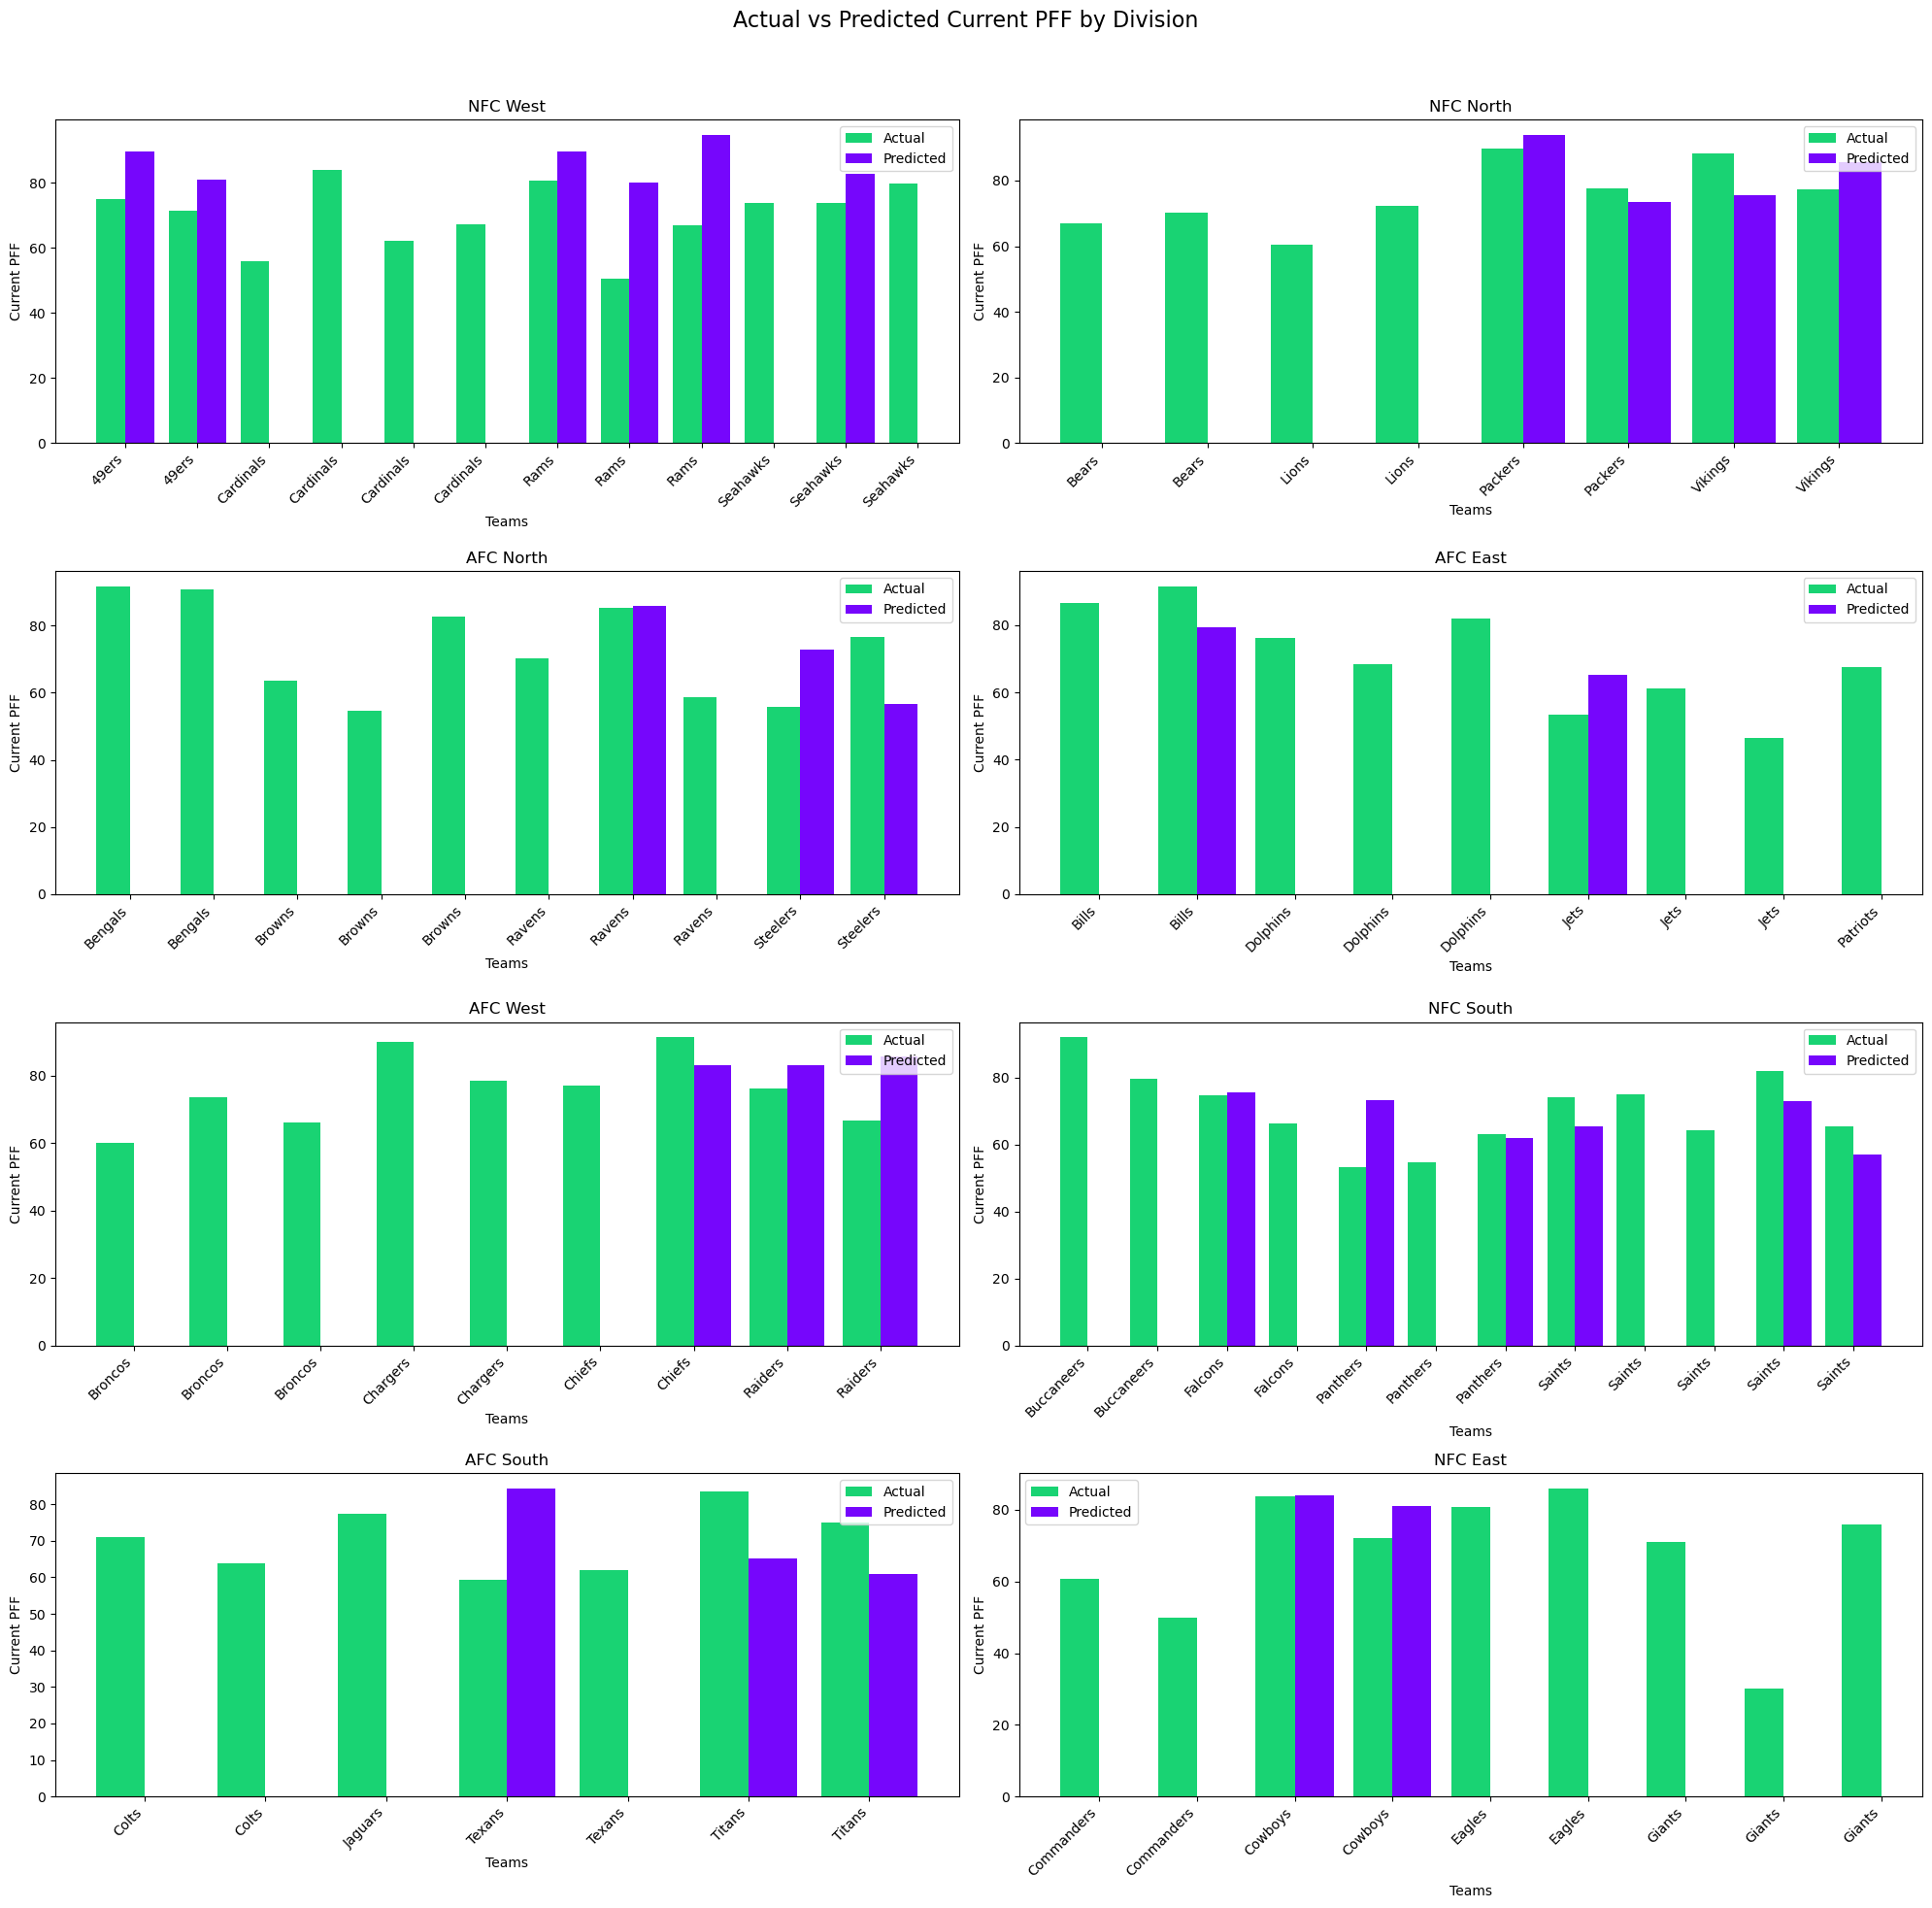

Epoch 1/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50.9064 - val_loss: 207.1597
Epoch 2/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.2700 - val_loss: 168.8766
Epoch 3/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62.5498 - val_loss: 169.6998
Epoch 4/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38.8213 - val_loss: 165.0846
Epoch 5/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47.9371 - val_loss: 169.8195
Epoch 6/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60.7390 - val_loss: 195.4651
Epoch 7/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62.3945 - val_loss: 180.0754
Epoch 8/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.1945 - val_loss: 183.4463
Epoch 9/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67.0772 - val_loss: 188.4814
Epoch 10/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36.8575 - val_loss: 186.2068
Epoch 11/750
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 77.0160 - val_loss: 170.1123
Epoch 12/750
16/16 ━━━━━━━━━━━

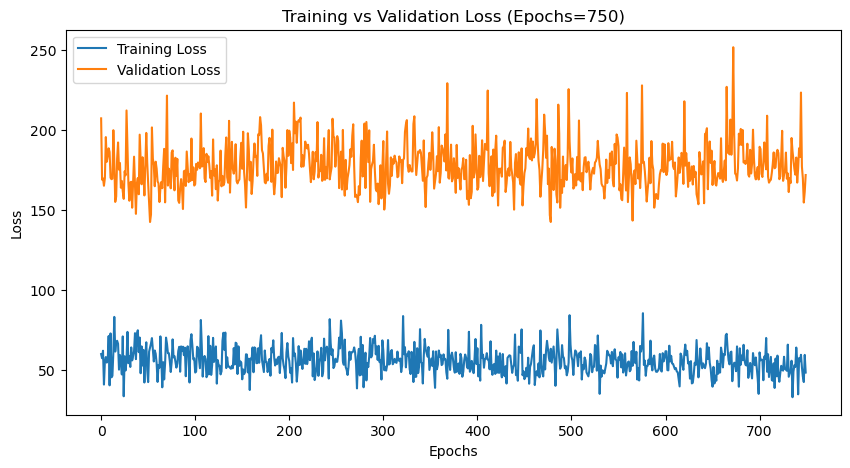

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Validation R² Score: -0.3196


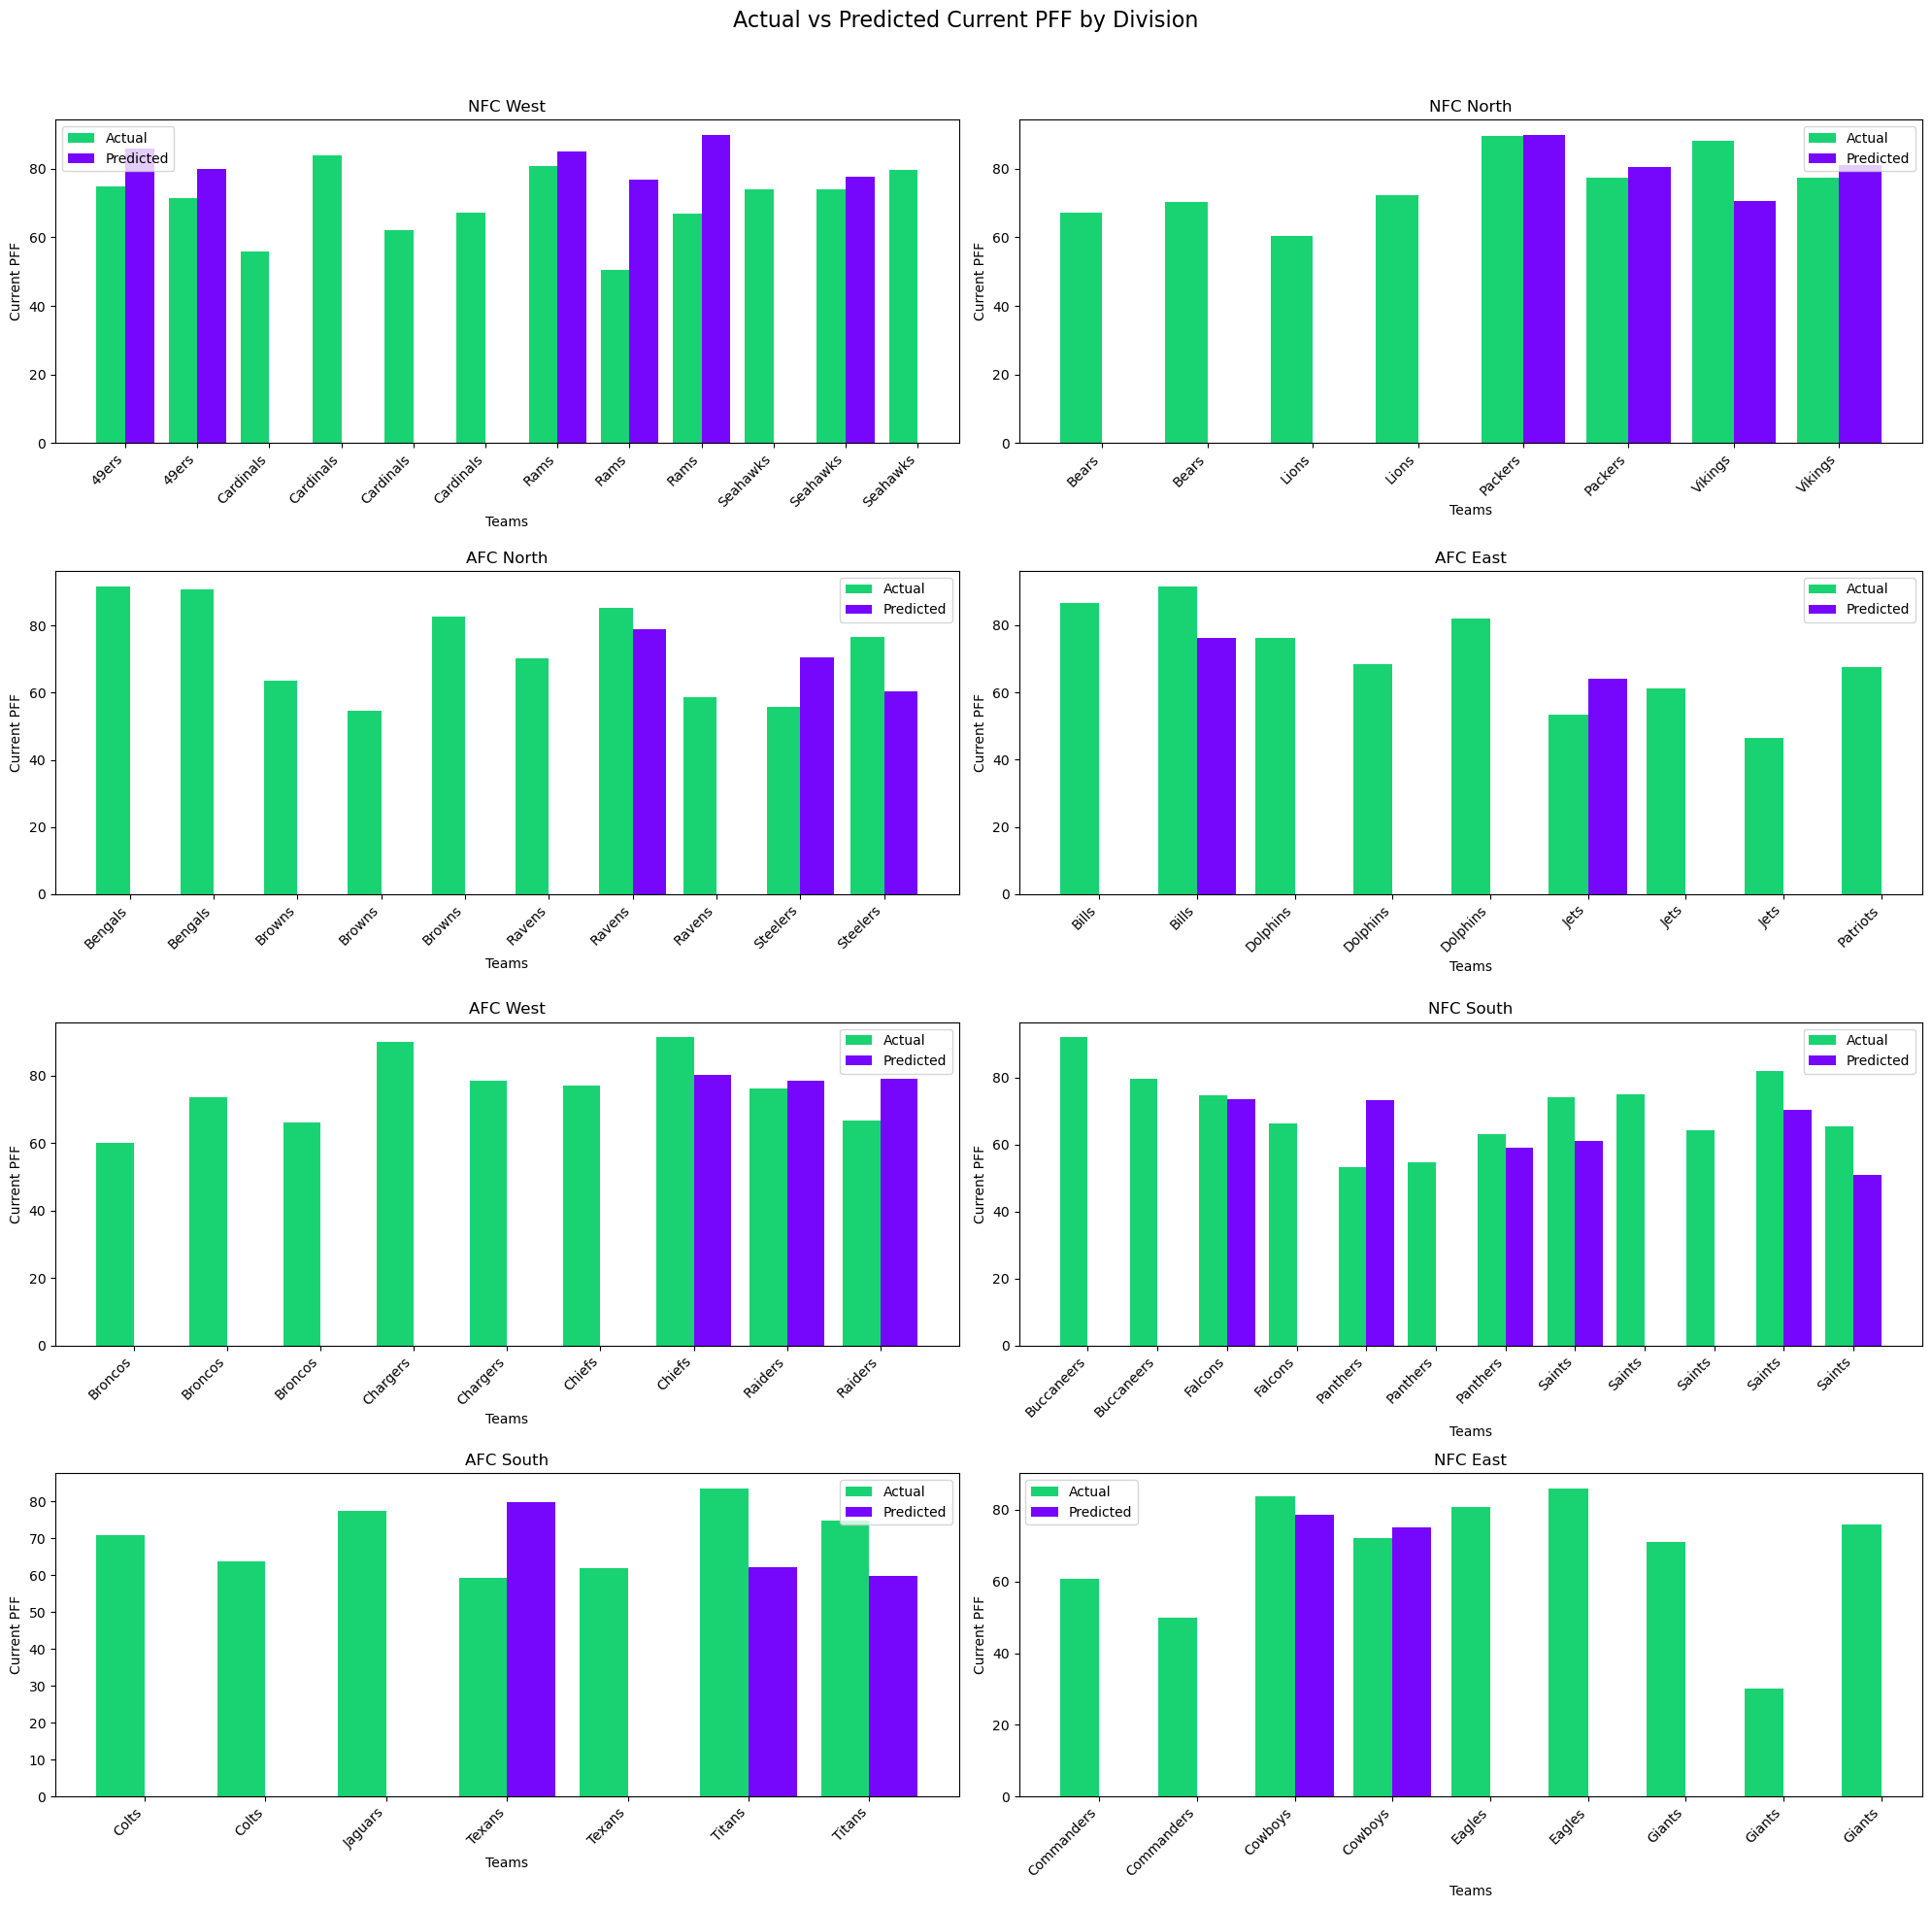

In [56]:
# -----------------------------
# Training loop with epoch_list
# -----------------------------
epoch_list = [80, 100, 150, 200, 250, 500, 750]
for e in epoch_list:
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=e,
        batch_size=8
    )
    
    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training vs Validation Loss (Epochs={e})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    r2 = r2_score(y_val, y_val_pred)
    print(f"Validation R² Score: {r2:.4f}")
    
    # -----------------------------
    # Map predictions to player + year
    # -----------------------------
    val_players_seq = players_seq[val_mask]
    val_targets_years = years_seq[val_mask]
    
    pred_df = pd.DataFrame({
        'player': val_players_seq,
        'Year': val_targets_years,
        'Predicted_PFF': y_val_pred.flatten()
    })
    
    # Merge predictions with actual data
    data_val = df[df['Year'].isin(val_targets_years)].copy()
    data_val = data_val.merge(pred_df, on=['player', 'Year'], how='left')
    
    # Add division info
    divisions = {
        "49ers": "NFC West", "Bears": "NFC North", "Bengals": "AFC North", "Bills": "AFC East",
        "Broncos": "AFC West", "Browns": "AFC North", "Buccaneers": "NFC South",
        "Cardinals": "NFC West", "Chargers": "AFC West", "Chiefs": "AFC West", "Colts": "AFC South",
        "Commanders": "NFC East", "Cowboys": "NFC East", "Dolphins": "AFC East", "Eagles": "NFC East",
        "Falcons": "NFC South", "Giants": "NFC East", "Jaguars": "AFC South", "Jets": "AFC East",
        "Lions": "NFC North", "Packers": "NFC North", "Panthers": "NFC South", "Patriots": "AFC East",
        "Raiders": "AFC West", "Rams": "NFC West", "Ravens": "AFC North", "Saints": "NFC South",
        "Seahawks": "NFC West", "Steelers": "AFC North", "Texans": "AFC South", "Titans": "AFC South",
        "Vikings": "NFC North"
    }
    data_val["Division"] = data_val["Team"].map(divisions)
    columns_to_keep = ['grades_offense', 'Predicted_PFF', 'Team', 'Division']
    data_val = data_val.loc[:, columns_to_keep]
    
    # Plot by division
    divs = data_val["Division"].unique()
    fig, axes = plt.subplots(4, 2, figsize=(20, 20))
    for ax, div in zip(axes.flatten(), divs):
        fig.suptitle(f'Actual vs Predicted Current PFF by Division', fontsize=16)
        div_data = data_val[data_val["Division"] == div]
        x = np.arange(len(div_data))
        width = 0.4
        ax.bar(x - width/2, div_data['grades_offense'], width, label='Actual', color='#19D373')
        ax.bar(x + width/2, div_data['Predicted_PFF'], width, label='Predicted', color='#7606FC')
        ax.set_xticks(x)
        ax.set_xticklabels(div_data['Team'], rotation=45, ha='right')
        ax.set_title(div)
        ax.set_xlabel('Teams')
        ax.set_ylabel('Current PFF')
        ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
